In [1]:
import pandas as pd
import numpy as np

## Data Prep

In [2]:
# Load data from file
df = pd.read_csv('HW3_Data.txt', delimiter='\t')

# Clean up column names, make heatmiser_id into index
df.columns = [x.lower().replace(' ', '_') for x in df.columns]
# df = df.set_index('heatmiser_id')

# Fix duo-naming of 'NonCompliant' / 'Non-Compliant'
df['osha'] = df['osha'].str.replace('-', '')

# Convert 'location_type' into OneHot encoding
df = pd.get_dummies(df, prefix='loc', columns=['location_type'])

df.head()

,heatmiser_id,distance_feature,speeding_feature,osha,loc_Office,loc_Warehouse
0,2018_01,53.76,9,Safe,1,0
1,2018_02,51.86,4,Safe,1,0
2,2018_03,51.59,4,Safe,1,0
3,2018_04,168.90,5,Safe,0,1
4,2018_05,53.50,5,Safe,1,0


## Scikit Learn

In [3]:
from sklearn import tree

In [4]:
def seperate_features(df):
    """Returns X=features and Y=labels"""
    X = df[['distance_feature', 'speeding_feature', 'loc_Office', 'loc_Warehouse']]
    Y = df['osha']
    return X, Y

In [5]:
X, Y = seperate_features(df)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

In [6]:
df.loc[12:14]

,heatmiser_id,distance_feature,speeding_feature,osha,loc_Office,loc_Warehouse
12,2018_13,185.39,20,Safe,0,1
13,2018_14,35.87,35,Compliant,1,0
14,2018_15,49.64,5,Safe,1,0


In [7]:
clf.predict(X.loc[12:14])

array(['Safe', 'Compliant', 'Safe'], dtype=object)

### Cross Validation

#### Using Built in tool

In [8]:
from sklearn.model_selection import cross_val_score

X, Y = seperate_features(df)
clf = tree.DecisionTreeClassifier()
cross_val_score(clf, X, Y, cv=10)

array([0.9925187 , 0.99501247, 0.98753117, 0.96259352, 0.98753117,
       0.98753117, 0.9925    , 0.96482412, 0.95226131, 0.98994975])

#### "By Hand"

See: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score

In [9]:
from sklearn.metrics import (accuracy_score, f1_score, precision_score)

In [10]:
def make_model(X, Y):
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X, Y)
    return clf

In [11]:
def evaluate_model(y_true, y_pred, stats):
    stats['accuracy'].append(
        accuracy_score(y_true, y_pred))
    stats['precision'].append(
        precision_score(y_true, y_pred, average='micro'))
    stats['f1'].append(
        f1_score(y_true, y_pred, average="micro"))
    return stats

In [12]:
def cross_val(df, k=10):
    """k-fold cross validation"""
    
    stats = {'accuracy':[], 'precision':[], 'f1':[]}
    
    # shuffle df
    shuffle_df = df.sample(frac=1)

    # partition into 10 chunks
    dfs = np.array_split(shuffle_df, 10)

    # build and test model with each chunk
    for i in range(10):
        
        dfs_copy = dfs[:]
        test_samples = dfs_copy.pop(i)
        train_samples = pd.concat(dfs_copy)

        X, Y = seperate_features(train_samples)
        X_test, Y_test = seperate_features(test_samples)

        clf = make_model(X, Y)
        stats = evaluate_model(Y_test, clf.predict(X_test), stats)
        
    return stats

In [13]:
stats = cross_val(df)

In [14]:
stats_df = pd.DataFrame(stats)
stats_df

,accuracy,f1,precision
0,0.9775,0.9775,0.9775
1,0.9875,0.9875,0.9875
2,0.9775,0.9775,0.9775
3,0.9900,0.9900,0.9900
4,0.9825,0.9825,0.9825
5,0.9750,0.9750,0.9750
6,0.9900,0.9900,0.9900
7,0.9850,0.9850,0.9850
8,0.9650,0.9650,0.9650
9,0.9775,0.9775,0.9775


In [15]:
stats_df.describe()

,accuracy,f1,precision
count,10.000000,10.000000,10.000000
mean,0.980750,0.980750,0.980750
std,0.007822,0.007822,0.007822
min,0.965000,0.965000,0.965000
25%,0.977500,0.977500,0.977500
50%,0.980000,0.980000,0.980000
75%,0.986875,0.986875,0.986875
max,0.990000,0.990000,0.990000


## Data Visualization

In [16]:
X, Y = seperate_features(df)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

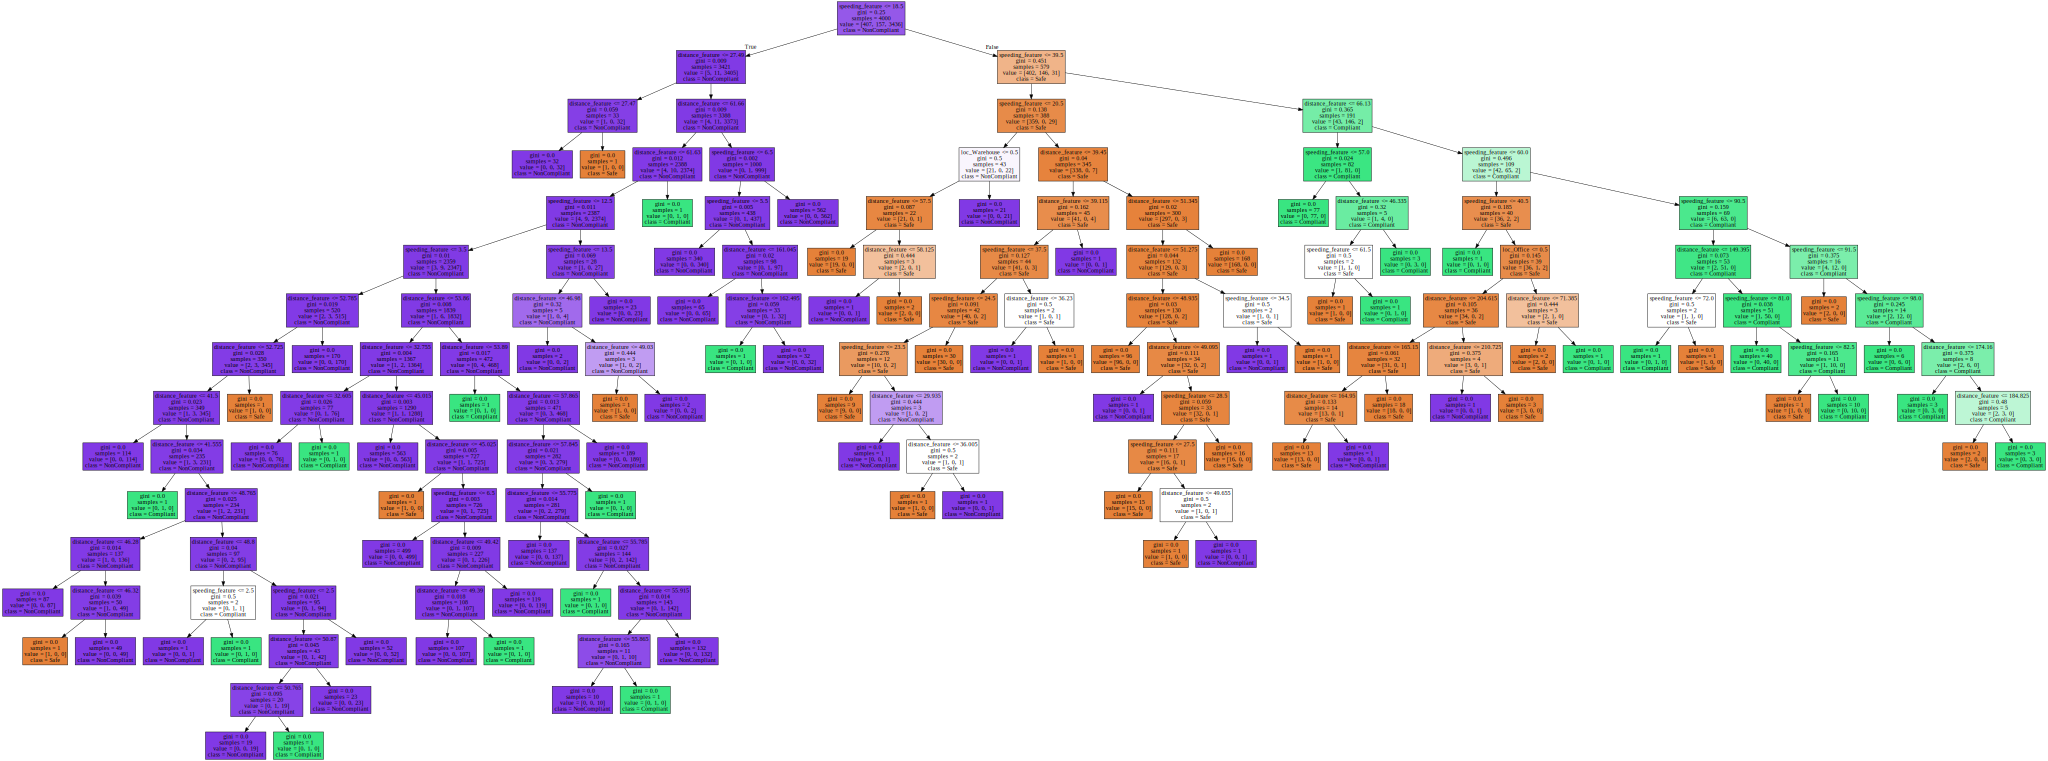

In [17]:
import graphviz 

dot_data = tree.export_graphviz(
    clf, out_file=None,
    feature_names=X.columns,
    class_names=Y.unique(),
    filled=True)

graph = graphviz.Source(dot_data)
graph.render(filename='tree')
graph